In [1]:
import os
from glob import glob
import shutil
import matplotlib.pyplot as plt
import re
import math
import numpy as np
# import pandas as pd
# from scipy.stats import chi2
import ot
from scipy.stats import wasserstein_distance

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
directory = os.getcwd()
print(directory)

/Users/hbakt/Desktop/code/rolling-dragons/BB_result_scripts


In [3]:
sub_dirs = glob("/Users/hbakt/Desktop/code/BB_results/all/*", recursive=True)
# sub_dirs = glob("/Users/hbakt/Desktop/code/rolling-dragons/meshes/BB_selection/*", recursive=True)
# print(sub_dirs)

In [4]:
face_pattern   = re.compile(r"f(\d+)")
ipc_pattern    = re.compile(r"IPC_prob\s?:\s+(-?\d+(\.\d+)?(e-\d+)?)")
bullet_pattern = re.compile(r"bullet_prob\s?:\s+(-?\d+(\.\d+)?(e-\d+)?)")
ours_pattern   = re.compile(r"my_prob\s?:\s+(-?\d+(\.\d+)?(e-\d+)?)")
# xyz_pattern  = re.compile(r'<(-?\d+(?:\.\d+)?),\s*(-?\d+(?:\.\d+)?),\s*(-?\d+(?:\.\d+)?)>')
xyz_pattern    = re.compile(r'<(-?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?),\s*(-?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?),\s*(-?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)>')
wight_ratio_pattern  = re.compile(r"ratio weights:\s+(-?\d+(\.\d+)?(e-\d+)?)")

In [5]:
def parse_our_log(our_log_text):
    faces = []
    probs = []
    normals = []
    wight_ratio = -1
    for line in our_log_text.splitlines():
        # print(line)
        r = re.search(face_pattern, line)
        if r is not None:
            face = int(r.group(1))
            faces.append(face)
        r = re.search(ours_pattern, line)
        if r is not None:
            ours = float(r.group(1))
            probs.append(ours)
        # r = re.search(xyz_pattern, line)
        matches = xyz_pattern.findall(line)
        if matches:
            for match in matches:
                x,y,z = map(float, match)
                normals.append(np.array([x,y,z]))
        r = re.search(wight_ratio_pattern, line)
        if r is not None:
            wight_ratio = float(r.group(1))/(4.*math.pi)
    return faces, probs, normals, wight_ratio

In [6]:
def parse_bullet_log(bullet_log_text):
    faces = []
    bullet_probs = []
    for line in bullet_log_text.splitlines():
        r = re.search(face_pattern, line)
        if r is not None:
            face = int(r.group(1))
            faces.append(face)
        r = re.search(bullet_pattern, line)
        if r is not None:
            bullet = float(r.group(1))
            bullet_probs.append(bullet)
    return faces, bullet_probs


In [7]:
def parse_ipc_log(ipc_log_text):
    faces = []
    ipc_probs = []
    for line in ipc_log_text.splitlines():
        r = re.search(face_pattern, line)
        if r is not None:
            face = int(r.group(1))
            faces.append(face)
        r = re.search(ipc_pattern, line)
        if r is not None:
            ipc = float(r.group(1))
            ipc_probs.append(ipc)
    return faces, ipc_probs


In [8]:

def kl(ms, other):
    kl = 0
    got_zero = False
    for p,q in zip(ms, other):
        if (p != 0) and (q != 0):
            kl += p * math.log(p/q)
        else:
            got_zero = True
            #
    # if (got_zero):
    #     print(" got zero")
    #     print(ms)
    #     print(other)
    #     print("kl: ", kl)
    return kl


In [9]:
def wasser_on_sphere(normals, p, q):
    assert(len(normals) == len(q))
    assert(len(p) == len(q))
    normals = np.array(normals)
    normals /= np.linalg.norm(normals, axis = 1)[:, None]
    # Compute the geodesic distance matrix between the two sets of points
    cost_matrix = np.arccos(np.clip(np.dot(normals, normals.T), -1, 1))  # geodesic distance on sphere
    # print("q sum:", np.sum(q), "  p sum:", np.sum(p))
    p /= np.sum(p)
    q /= np.sum(q)
    wasser_distance = ot.emd2(p, q, cost_matrix, check_marginals=True)
    return wasser_distance

In [13]:
filenames = ["m0_p0", "m2_p0", "m2_p1", "m2_p2"]
data_ipc_ours = []
data_ours_ipc = []
data_bullet_ours = []
data_ours_bullet = []
data_bullet_ipc = []
data_ipc_bullet = []

data_us_ipc_OT = []
data_us_bullet_OT = []
data_ipc_bullet_OT = []

data_bullet_invalids = []

data_weight_ratios = []

wass_dists = []
count = 0
for sd in sub_dirs:
    # print(sd)
    id = sd.split("/")[-1]
    for fname in filenames:
        IPC_full_path = os.path.join(sd, fname + "_logs", fname + "_IPC") + ".txt"
        bullet_full_path = os.path.join(sd, fname + "_logs", fname + "_bullet") + ".txt"
        our_full_path = os.path.join(sd, fname + "_logs", fname + "_just_ours") + ".txt"
        if os.path.exists(bullet_full_path) and os.path.exists(IPC_full_path) and os.path.exists(our_full_path):
            IPC_txt = open(IPC_full_path, "r")
            IPC_str = IPC_txt.read()
            faces_IPC, ipc_prob = parse_ipc_log(IPC_str)

            bullet_txt = open(bullet_full_path, "r")
            bullet_str = bullet_txt.read()
            faces_bullet, bullet_prob = parse_bullet_log(bullet_str)

            our_txt = open(our_full_path, "r")
            our_str = our_txt.read()
            faces_ours, ours_prob, our_normals, weight_ratio = parse_our_log(our_str)

            # check face intersections
            common_elements = list(set(faces_IPC) & set(faces_ours))
            if (len(common_elements) != len(faces_ours)) or (len(common_elements) != len(faces_IPC)):
                print("shape", id, " ", fname, "---------")
                print("Common elements not matching:", common_elements)
                print("faces IPC    : ", faces_IPC)
                print("faces ours   :", faces_ours)
                print("faces Bullet : ", faces_bullet)
                print("Bullet prob  :", bullet_prob)
                print("IPC prob     : ", ipc_prob)
                print("ours prob    :", ours_prob)
                print("weight ratio:", weight_ratio)
                count += 1
            # print("Common elements:", common_elements)
            # print ("--------- log vals: ", id, " ", fname, "---------" )
            # print("faces IPC    : ", faces_IPC)
            # print("IPC prob     : ", ipc_prob)
            # # # print("bullet text:", bullet_txt)
            # print("faces Bullet : ", faces_bullet)
            # print("Bullet prob  :", bullet_prob)
            # # #
            # # print("normals:", normals)
            # print("faces ours   :", faces_ours)
            # print("ours prob    :",  ours_prob)
            # print(" ours sum:", abs(1-np.sum(ours_prob)))
            # print("weight ratio:", weight_ratio)
            # print(normals)

            OT_us_ipc = wasser_on_sphere(our_normals, ours_prob, ipc_prob)
            data_us_ipc_OT.append(tuple([id+"_"+fname, OT_us_ipc]))
            OT_us_bullet = wasser_on_sphere(our_normals, ours_prob, bullet_prob)
            data_us_bullet_OT.append(tuple([id+"_"+fname, OT_us_bullet]))
            OT_ipc_bullet = wasser_on_sphere(our_normals, ipc_prob, bullet_prob)
            data_ipc_bullet_OT.append(tuple([id+"_"+fname, OT_ipc_bullet]))
            kl_ipc_us = kl(ipc_prob, ours_prob)
            kl_us_ipc = kl(ours_prob, ipc_prob)
            kl_bullet_us = kl(bullet_prob, ours_prob)
            kl_us_bullet = kl(ours_prob, bullet_prob)
            kl_bullet_ipc = kl(bullet_prob, ipc_prob)
            kl_ipc_bullet = kl(ipc_prob, bullet_prob)
            #
            # if (kl_ipc_us < 0) or kl_us_ipc < 0:
            #     print ("--------- log vals: ", id, " ", fname, "---------" )
            #     print(sd)
            #     print(np.sum())
            #     print(kl_ipc_us, kl_us_ipc)
            data_ipc_ours.append(tuple([id+"_"+fname, kl_ipc_us]))
            data_ours_ipc.append(tuple([id+"_"+fname, kl_us_ipc]))
            data_bullet_ours.append(tuple([id+"_"+fname, kl_bullet_us]))
            data_ours_bullet.append(tuple([id+"_"+fname, kl_us_bullet]))
            data_bullet_ipc.append(tuple([id+"_"+fname, kl_bullet_ipc]))
            data_ipc_bullet.append(tuple([id+"_"+fname, kl_ipc_bullet]))
            data_bullet_invalids.append(tuple([id+"_"+fname, 1 - np.sum(bullet_prob)]))
            data_weight_ratios.append(tuple([id+"_"+fname, weight_ratio]))
            # wass_dists.append(tuple([id+"_"+fname, wasserstein_distance(ipc_prob, ours_prob)]))
print("count:", count)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [11]:
# len(data_us_ipc_OT)
len(data_us_bullet_OT)

672

In [14]:
min_kl = -0.5
max_kl = 2
bins = np.linspace(min_kl - 0.01, max_kl + 0.01, 35)

ylim = [0,350]
xlim = [min_kl, max_kl]

yticks = [0, 50, 100, 150, 200, 250, 300]

min_OT = 0
max_OT = 1.8
OT_bins = np.linspace(min_OT, max_OT, 35)

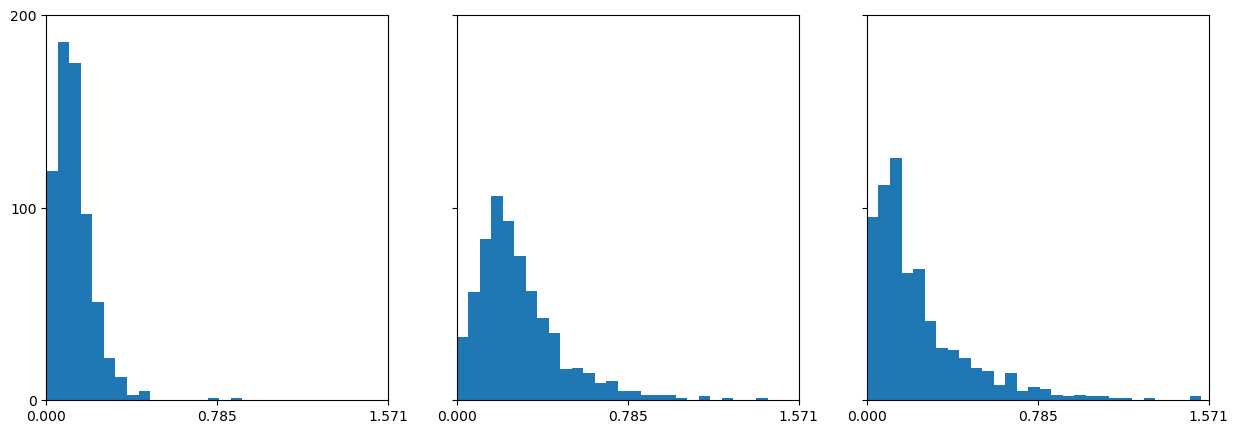

In [15]:
# Create the figure and axes
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
# fig, ax = plt.subplots()
axes[0].hist([e[1] for e in data_us_ipc_OT    ],     bins=OT_bins, alpha=1., label='OT IPC,ours')
# axes[0].set_title("Ours vs IPC")
axes[1].hist([e[1] for e in data_us_bullet_OT ],  bins=OT_bins, alpha=1., label='OT Bullet,ours')
# axes[1].set_title("Ours vs Bullet")
axes[2].hist([e[1] for e in data_ipc_bullet_OT], bins=OT_bins, alpha=1., label='OT IPC,Bullet')
# axes[2].set_title("IPC vs Bullet")
for ax in axes:
    ax.set_xlim([0, math.pi/2.])
    ax.set_ylim([0, 200])
    ax.set_yticks([0, 100, 200])
    ax.set_xticks([0, math.pi/4., math.pi/2.])
    # ax.set_xlabel("Wasserstein distance")
    # ax.set_ylabel("count")

# Add a legend
# plt.legend()
# plt.yticks(yticks)
# plt.ylim([0, 130])
# plt.title("Histogram IPC vs ours KL divs")
# plt.title("Histogram of OT(IPC,ours)")
plt.savefig("plots/OT_on_sphere.png", dpi=900)
# plt.savefig("OT_ipc_ours.png")
plt.show()


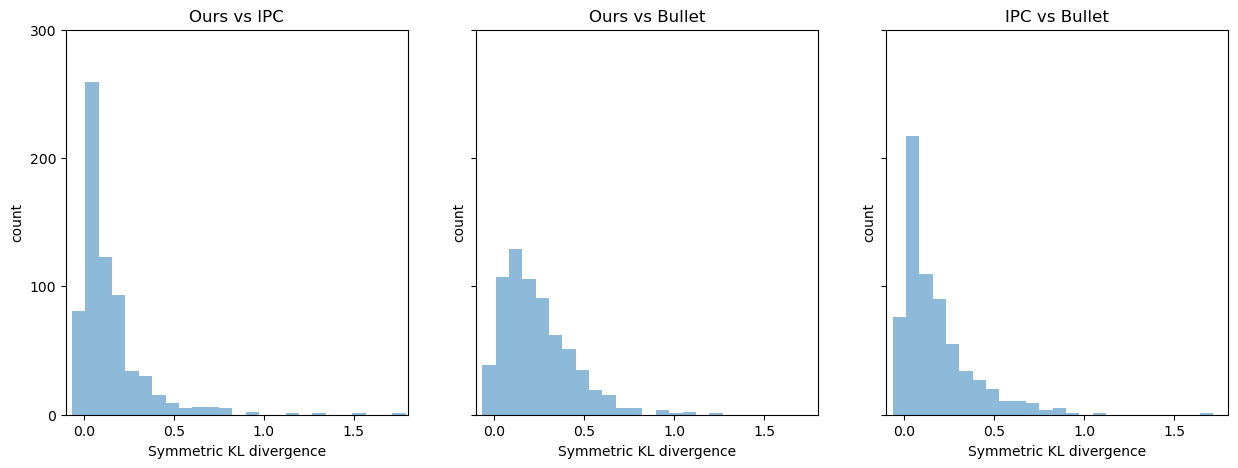

In [49]:
# Create the figure and axes
# fig, ax = plt.subplots()
# ax.hist([float(e[1]) for e in data_ipc_ours], bins=bins, alpha=0.5, label='IPC|ours')
# ax.hist([float(e[1]) for e in data_ours_ipc], bins=bins, alpha=0.5, label='ours|IPC')
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
# fig, ax = plt.subplots()
axes[0].hist([float(e[1] + p[1])/2 for e, p in zip(data_ipc_ours, data_ours_ipc)], bins=bins, alpha=0.5, label='Symm KL IPC,ours')
axes[0].set_title("Ours vs IPC")
axes[1].hist([float(e[1] + p[1])/2 for e, p in zip(data_bullet_ours, data_ours_bullet)], bins=bins, alpha=0.5, label='Symm KL Bullet,ours')
axes[1].set_title("Ours vs Bullet")
axes[2].hist([float(e[1] + p[1])/2 for e, p in zip(data_bullet_ipc, data_ipc_bullet)], bins=bins, alpha=0.5, label='Symm KL Bullet,IPC')
axes[2].set_title("IPC vs Bullet")
for ax in axes:
    ax.set_xlim([-0.1, 1.8])
    ax.set_ylim([0, 300])
    ax.set_yticks([0, 100, 200, 300])
    ax.set_xticks([0, 0.5, 1, 1.5])
    ax.set_xlabel("Symmetric KL divergence")
    ax.set_ylabel("count")

# Add a legend
# plt.yticks(yticks)
# plt.title("Histogram IPC vs ours KL divs")
# plt.title("Histogram IPC vs ours symmetric KL divs")
# plt.savefig("KL_divs_ipc_ours.png")
plt.savefig("plots/Symm_KL hists.png")
plt.show()

In [16]:
# write data_weight_ratios and data_us_ipc_OT and data_us_bullet_OT and data_ipc_bullet_OT to CSV file
# without sorting
# import csv
# with open('./CSVs/simulation_data.csv', 'w') as f:
#     # using csv.writer method from CSV package
#     write = csv.writer(f)
#     write.writerow(['id', 'weight_ratio', 'OT_us_IPC', 'OT_us_Bullet', 'OT_IPC_Bullet'])
#     for i in range(len(data_weight_ratios)):
#         write.writerow([data_weight_ratios[i][0], data_weight_ratios[i][1], data_us_ipc_OT[i][1], data_us_bullet_OT[i][1], data_ipc_bullet_OT[i][1]])


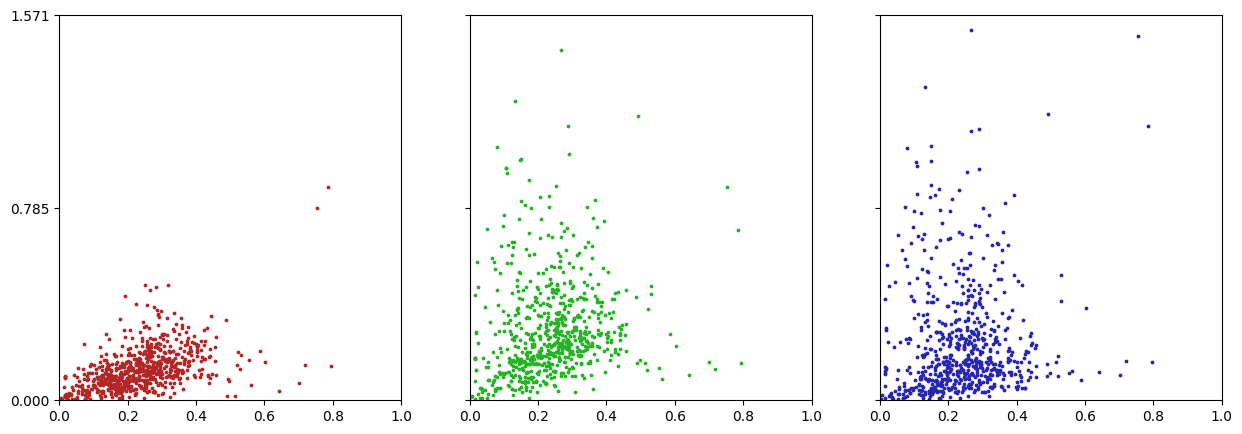

IPC vs Bullet
IPC vs Bullet:  0.07217001691695592
ours vs IPC:  0.4717244252263169
ours vs Bullet:  0.13317884569041244
IPC vs Bullet:  PearsonRResult(statistic=np.float64(0.07217001691695597), pvalue=np.float64(0.06150931675197623))
ours vs IPC:  PearsonRResult(statistic=np.float64(0.4717244252263173), pvalue=np.float64(1.559471449265571e-38))
ours vs Bullet:  PearsonRResult(statistic=np.float64(0.13317884569041258), pvalue=np.float64(0.0005373870461840612))


/var/folders/sb/1nc3m2qd0pzfb6g5h9t08tf40000gn/T/ipykernel_9759/3116361987.py:33: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


In [194]:
w             = np.array([float(e[1]) for e in data_weight_ratios])
us_IPC_OT     = np.array([float(e[1]) for e in data_us_ipc_OT])
us_Bullet_OT  = np.array([float(e[1]) for e in data_us_bullet_OT])
IPC_Bullet_OT = np.array([float(e[1]) for e in data_ipc_bullet_OT])


fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
# fig, ax = plt.subplots()
axes[0].scatter(w, us_IPC_OT,     s = 3, color = [0.7,0.15,0.15], label='ours vs IPC')
# axes[0].set_title("Ours vs IPC")
axes[1].scatter(w, us_Bullet_OT,  s = 3, color = [0.15,0.7,0.15], label='ours vs Bullet')
# axes[1].set_title("Ours vs Bullet")
axes[2].scatter(w, IPC_Bullet_OT, s = 3, color = [0.15,0.15,0.7], label='IPC vs Bullet')
# axes[2].set_title("IPC vs Bullet")
for ax in axes:
    ax.set_xlim([0, 1])
    ax.set_ylim([0, math.pi/2.])
    # ax.set_xticks([0, 0.2, 1])
    ax.set_yticks([0, math.pi/4., math.pi/2.])
    # ax.set_xlabel("MS complex weighted distance ratio")
    # ax.set_ylabel("OT on sphere")
    # ax.set_aspect('square', 'box')
# plt.legend()
# plt.tight_layout()
plt.savefig("plots/OT_vs_weight_ratio.png", dpi=900)
plt.show()

# print correlations
print("IPC vs Bullet")
print("IPC vs Bullet: ", np.corrcoef (w, IPC_Bullet_OT)[0,1])
print("ours vs IPC: ", np.corrcoef   (w, us_IPC_OT)[0,1])
print("ours vs Bullet: ", np.corrcoef(w, us_Bullet_OT)[0,1])
from scipy.stats.stats import pearsonr
print("IPC vs Bullet: ", pearsonr(w, IPC_Bullet_OT))
print("ours vs IPC: ", pearsonr(w, us_IPC_OT))
print("ours vs Bullet: ", pearsonr(w, us_Bullet_OT))

In [120]:

high_IPC_Bullet = []
high_us_IPC = []
high_us_Bullet = []
thresh = 1
print("IPC vs Bullet")
for i, e in enumerate(data_ipc_bullet_OT):
    if e[1] > thresh and w[i] <0.2:
        print(e, w[i])
        high_IPC_Bullet.append(e)
print("ours vs IPC")
for i, e in enumerate(data_us_ipc_OT):
    if e[1] > thresh and w[i] <0.2:
        print(e, w[i])
        high_IPC_Bullet.append(e)
print("ours vs Bullet")
for i, e in enumerate(data_us_bullet_OT):
    if e[1] > thresh:
        print(e, w[i])
        high_us_Bullet.append(e)
# common_elements = list(set([e[0] for e in high_us_IPC]) & set([e[0] for e in high_us_Bullet]))
# print("Common elements:", common_elements)
#
# common_elements = list(set([e[0] for e in high_IPC_Bullet]) & set([e[0] for e in high_us_Bullet]))
# print("Common elements:", common_elements)
#
# common_elements = list(set([e[0] for e in high_IPC_Bullet]) & set([e[0] for e in high_us_IPC]))
# print("Common elements:", common_elements)

IPC vs Bullet
('437348_sf_m2_p2', 1.1017772679111622) 0.13730296940537812
('64194_sf_m0_p0', 1.029491820446624) 0.08025706315295006
('1436278_sf_m2_p1', 1.129787516876943) 0.1579103514369167
('93101_sf_m2_p2', 1.0280708667459484) 0.1456180194072142
('96481_sf_m2_p0', 1.0992154178782125) 0.09717762092776493
('250143_sf_m2_p1', 1.084756261904065) 0.1946289883576479
('682289_sf_m2_p2', 1.534317513267815) 0.038520748341360704
('133077_sf_m2_p1', 1.405058440424474) 0.10740173447198828
('1436273_sf_m2_p1', 1.4728148998668131) 0.18091142381255745
('81589_sf_m2_p2', 1.1791754019429375) 0.1387799272772709
('75655_sf_m2_p1', 1.036161740519318) 0.14829420977530441
('338509_sf_m2_p1', 1.5346156968283782) 0.07775984251836668
('682291_sf_m2_p2', 1.426239826191738) 0.07077031446007145
('103737_sf_m2_p2', 1.232766881731641) 0.17885434617309467
('98480_sf_m2_p2', 1.2062973214131452) 0.1331951803241763
('96483_sf_m2_p0', 1.1196182194912538) 0.1742921697293655
ours vs IPC
('682289_sf_m2_p2', 1.4592158167

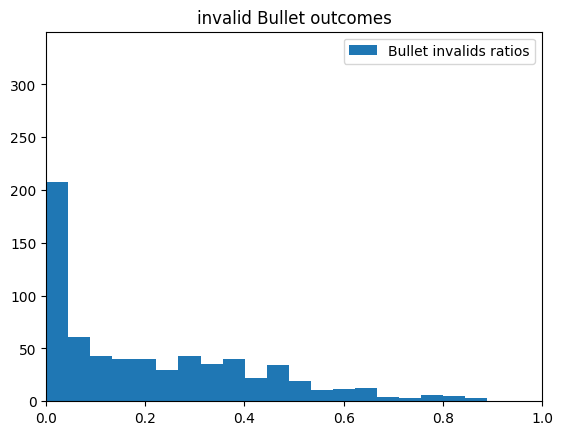

In [58]:
fig, ax = plt.subplots()
ax.hist([float(e[1]) for e in data_bullet_invalids], bins=20, label='Bullet invalids ratios')


# Add a legend
plt.legend()
plt.xlim([0,1])
plt.yticks(yticks)
plt.ylim(ylim)
# plt.title("Histogram IPC vs ours KL divs")
plt.title("invalid Bullet outcomes")
# plt.savefig("ratio of invalid Bullet results.png")
plt.show()

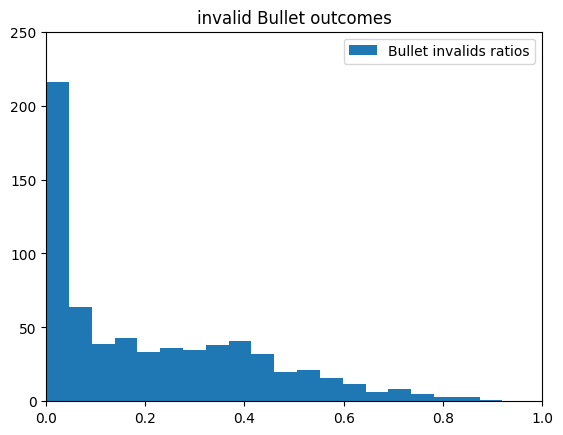

In [105]:
fig, ax = plt.subplots()
ax.hist([float(e[1]) for e in data_bullet_invalids], bins=20, label='Bullet invalids ratios')


# Add a legend
plt.legend()
plt.xlim([0,1])
# plt.yticks([0,250])
plt.ylim([0,250])
# plt.title("Histogram IPC vs ours KL divs")
plt.title("invalid Bullet outcomes")
plt.savefig("plots/ratio of invalid Bullet results.png")
plt.show()

In [191]:
sorted_bullet_invalid = sorted(data_bullet_invalids, key=lambda x: x[1])
with open('BulleT_invalids_sorted.txt', 'w') as file:
    # Write each element of the list on a new line
    for element in sorted_bullet_invalid:
        file.write(element[0] +": " + element[1].__str__() + '\n')


In [189]:
sorted_ours_ipc    = sorted(data_ours_ipc, key=lambda x: x[1])
sorted_ipc_ours    = sorted(data_ipc_ours, key=lambda x: x[1])
sorted_ours_bullet = sorted(data_ours_bullet, key=lambda x: x[1])
sorted_bullet_ours = sorted(data_bullet_ours, key=lambda x: x[1])
sorted_ipc_bullet  = sorted(data_ipc_bullet, key=lambda x: x[1])
sorted_bullet_ipc  = sorted(data_bullet_ipc, key=lambda x: x[1])

#  ours , IPC
with open('KL_ours_ipc_sorted.txt', 'w') as file:
    # Write each element of the list on a new line
    for element in sorted_ours_ipc:
        file.write(element[0] +": " + element[1].__str__() + '\n')
with open('KL_ipc_ours_sorted.txt', 'w') as file:
    # Write each element of the list on a new line
    for element in sorted_ipc_ours:
        file.write(element[0] +": " + element[1].__str__() + '\n')

#  ours, Bullet
with open('KL_ours_Bullet_sorted.txt', 'w') as file:
    # Write each element of the list on a new line
    for element in sorted_ours_bullet:
        file.write(element[0] +": " + element[1].__str__() + '\n')
with open('KL_Bullet_ours_sorted.txt', 'w') as file:
    # Write each element of the list on a new line
    for element in sorted_bullet_ours:
        file.write(element[0] +": " + element[1].__str__() + '\n')

#  ours, Bullet
with open('KL_IPC_Bullet_sorted.txt', 'w') as file:
    # Write each element of the list on a new line
    for element in sorted_ipc_bullet:
        file.write(element[0] +": " + element[1].__str__() + '\n')
with open('KL_Bullet_IPC_sorted.txt', 'w') as file:
    # Write each element of the list on a new line
    for element in sorted_bullet_ipc:
        file.write(element[0] +": " + element[1].__str__() + '\n')

In [11]:
ms = [0.0726678,0.00627259,0.0104082,0.0104924,0.00641055,0.0736104,0.338014,0.0706091,0.0732585,0.00595346,0.332303]
ipc = [0.018970,0.0223214,0.00669643,0.00892857,0.00223214,0.0223214,0.569196,0.0223214,0.0245536,0.00111607,0.320312]
bullet =   [0.000997009, 0.000421811, 0.00230079 , 0.00207071 , 0.000613544, 0.000690237, 0.657796, 0.00076693 , 0.00149551 , 0.000115039, 0.332733 ]
print("KL(ours  , ipc)   : ", kl(ms, ipc))
print("KL(ipc   , ours)  : ", kl(ipc, ms))
print("KL(ours  , bullet): ", kl(ms, bullet))
print("KL(bullet, ours)  : ", kl(bullet, ms))
print("KL(bullet, ipc)   : ", kl(bullet, ipc))
print("KL(ipc   , bullet): ", kl(ipc, bullet))
# kl(ms, ipc)
# kl(ipc, ms)
# kl(ms, bullet)
# kl(bullet, ms)
# kl(ipc, bullet)
# kl(bullet, ipc)


KL(ours  , ipc)   :  0.19793896713001602
KL(ipc   , ours)  :  0.19991527479961646
KL(ours  , bullet):  1.1225305644571149
KL(bullet, ours)  :  0.41174318934012355
KL(bullet, ipc)   :  0.08750349111598761
KL(ipc   , bullet):  0.29710860867490646


In [28]:
piggy_log_path = "/Users/hbakt/Desktop/code/rolling-dragons/meshes/pass_the_piggies/piggy_logs/piggy_just_ours.txt"
our_txt = open(piggy_log_path, "r")
our_str = our_txt.read()
faces_ours, ours_prob, our_normals, weight_ratio = parse_our_log(our_str)

#modify
our_normals = [our_normals[0], our_normals[2], our_normals[4], our_normals[5], our_normals[6], our_normals[-2]]
ours_prob =   [0.318842      , 0.2697        , 0.2078        , 0.1019        , 0.05321       , 0.03814]
ours_prob = [p/sum(ours_prob) for p in ours_prob]
print(ours_prob)

[0.32219540982546346, 0.27253656052191205, 0.20998552938989, 0.10297172976337725, 0.053769634354360184, 0.038541136144997136]


In [30]:
wiki_probs = [0.349, 0.302, 0.224, 0.088, 0.03, 0.0061]

OT_us_wiki = wasser_on_sphere(our_normals, ours_prob, wiki_probs)
print("OT us wiki:", OT_us_wiki)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
OT us wiki: 0.09293508725646746


In [31]:
kl(ours_prob, wiki_probs)

0.05131056199150889

In [33]:
math.pi/0.092

34.147746234671665

In [50]:
3.16524/(4*math.pi)

0.2518817960360954